# Dynamical Magnetic X-ray Scattering

In this example static and transient magnetic X-ray simulations are carried out employing a dynamical magnetic X-ray scattering formalism which was adapted from [Project Dyna](http://dyna.neel.cnrs.fr).

## Setup

Do all necessary imports and settings.

In [1]:
import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib()  # use matplotlib with pint units

## Structure

Refer to the [structure-example](structure.ipynb) for more details.

In this example the sample `Structure` consists of `AmorphousLayer`s.

In order to build an antiferromagnetic sample two different types of _Fe_ `Atom`s and `AmorphousLayer`s are created with opposite in-plane magnetization.

Here a local file for the atomic scattering factor is read only for Fe atoms.

In [2]:
Fe_right = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=90*u.deg,
                   atomic_form_factor_path='./Fe.cf')
Fe_left = ud.Atom('Fe', mag_amplitude=1, mag_phi=90*u.deg, mag_gamma=270*u.deg,
                  atomic_form_factor_path='./Fe.cf')
Cr = ud.Atom('Cr')
Si = ud.Atom('Si')

In [3]:
density_Fe = 7874*u.kg/u.m**3

prop_Fe = {}
prop_Fe['heat_capacity'] = 449*u.J/u.kg/u.K
prop_Fe['therm_cond'] = 80*u.W/(u.m *u.K)
prop_Fe['lin_therm_exp'] = 11.8e-6
prop_Fe['sound_vel'] = 4.910*u.nm/u.ps
prop_Fe['opt_ref_index'] = 2.9174+3.3545j

layer_Fe_left = ud.AmorphousLayer('Fe_left', 'Fe left amorphous', 1*u.nm, density_Fe, atom=Fe_left, **prop_Fe)
layer_Fe_right = ud.AmorphousLayer('Fe_right', 'Fe right amorphous', 1*u.nm, density_Fe, atom=Fe_right, **prop_Fe)

In [4]:
density_Cr = 7140*u.kg/u.m**3

prop_Cr = {}
prop_Cr['heat_capacity'] = 449*u.J/u.kg/u.K
prop_Cr['therm_cond'] = 94*u.W/(u.m*u.K)
prop_Cr['lin_therm_exp'] = 6.2e-6
prop_Cr['sound_vel'] = 5.940*u.nm/u.ps
prop_Cr['opt_ref_index'] = 3.1612+3.4606j

layer_Cr = ud.AmorphousLayer('Cr', "Cr amorphous", 1*u.nm, density_Cr, atom=Cr, **prop_Cr)

In [5]:
density_Si = 2336*u.kg/u.m**3

prop_Si = {}
prop_Si['heat_capacity'] = 703*u.J/u.kg/u.K
prop_Si['therm_cond'] = 150*u.W/(u.m*u.K)
prop_Si['lin_therm_exp'] = 2.6e-6
prop_Si['sound_vel'] = 8.433*u.nm/u.ps
prop_Si['opt_ref_index'] = 3.6941+0.0065435j

layer_Si = ud.AmorphousLayer('Si', "Si amorphous", 1*u.nm, density_Si, atom=Si, **prop_Si)

In [6]:
S = ud.Structure('Fe/Cr AFM Super Lattice')

# create a sub-structure
DL = ud.Structure('Two Fe/Cr Double Layers')
DL.add_sub_structure(layer_Fe_left, 1)
DL.add_sub_structure(layer_Cr, 1)
DL.add_sub_structure(layer_Fe_right, 1)
DL.add_sub_structure(layer_Cr, 1)

S.add_sub_structure(DL, 10)
S.add_sub_structure(layer_Fe_left, 10)
S.add_sub_structure(layer_Si, 200)

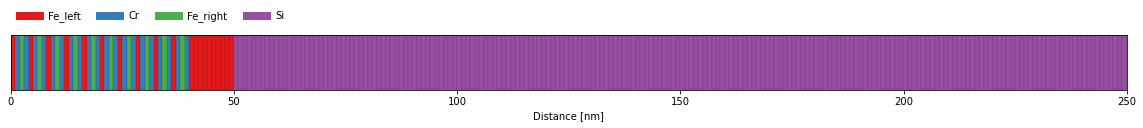

In [7]:
S.visualize()

## Heat

Refer to the [heat-example](heat.ipynb) for more details.

In [8]:
h = ud.Heat(S, True)

h.save_data = False
h.disp_messages = True

h.excitation = {'fluence': [40]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [1]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 45*u.deg}

# enable heat diffusion
h.heat_diffusion = True

# temporal and spatial grid
delays = np.r_[-2:40:0.1]*u.ps
_, _, distances = S.get_distances_of_layers()

In [9]:
temp_map, delta_temp_map = h.get_temp_map(delays, 0*u.K)

Surface incidence fluence scaled by factor 0.7071 due to incidence angle theta=45.00 deg
Calculating _heat_diffusion_ for excitation 1:1 ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 47.7 % and transmission of 6.4 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_ with 1 excitation(s): 12.861751 s
Calculating _heat_diffusion_ without excitation...


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 6.424054 s
Elapsed time for _temp_map_: 19.422909 s


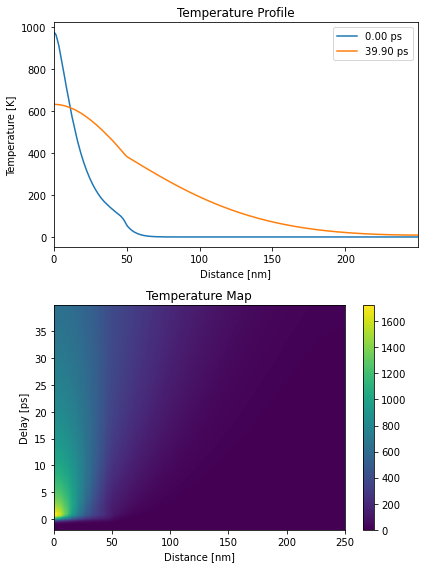

In [10]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, temp_map[20, :], label='{:0.2f} ps'.format(delays[20].to('ps').magnitude))
plt.plot(distances.to('nm').magnitude, temp_map[-1, :], label='{:0.2f} ps'.format(delays[-1].to('ps').magnitude))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Temperature [K]')
plt.legend()
plt.title('Temperature Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map, shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map')

plt.tight_layout()
plt.show()

## Numerical Phonons

Refer to the [phonons-example](phonons.ipynb) for more details.

In [11]:
p = ud.PhononNum(S, True)
p.save_data = False
p.disp_messages = True

In [12]:
strain_map = p.get_strain_map(delays, temp_map, delta_temp_map)

Calculating linear thermal expansion ...
Calculating coherent dynamics with ODE solver ...


0it [00:00, ?it/s]

Elapsed time for _strain_map_: 0.422739 s


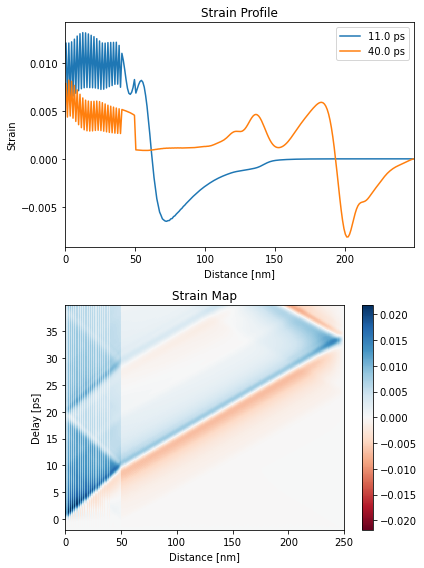

In [13]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, strain_map[130, :], label=np.round(delays[130]))
plt.plot(distances.to('nm').magnitude, strain_map[-1, :], label=np.round(delays[-1]))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Strain')
plt.legend()
plt.title('Strain Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude,
               strain_map, cmap='RdBu',
               vmin=-np.max(strain_map), vmax=np.max(strain_map), shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Strain Map')

plt.tight_layout()
plt.show()

## Magnetization

The `Magnetization` class is currently only an interface to allow the user for defining specific magnetization dynamics depending on the `strain_map` and `temp_map`.

Here the magnetization as function of temperature is used as a simplified model to alter the transient magnetization amplitude.

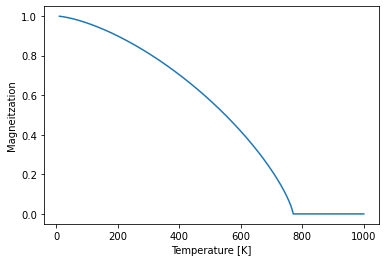

In [14]:
def magnetization_bloch(x, Tc, M0, beta):
    m = M0*((1-(x/Tc)**(3/2))*np.heaviside(Tc-x, 0.5))**beta
    return m


plt.figure()
temperatures = np.r_[10:1000:0.1]
plt.plot(temperatures, magnetization_bloch(temperatures, 770, 1, 0.75))
plt.xlabel('Temperature [K]')
plt.ylabel('Magneitzation')
plt.show()

The `calc_magnetization_map` method must be overwritten to allow for calculating magnetization dynamics.

In [15]:
class SimpleMagnetization(ud.Magnetization):

    def calc_magnetization_map(self, delays, **kwargs):
        temp_map = kwargs['temp_map']
        T_c = kwargs['T_c']
        magnetization_map = np.zeros([len(delays), self.S.get_number_of_layers(), 3])
        handles = self.S.get_layer_vectors()[2]

        for i, handle in enumerate(handles):
            if handle.id in ['Fe_left', 'Fe_right']:
                magnetization_map[:, i, 0] = magnetization_bloch(temp_map[:, i], T_c, 1, .75)
            handle.magnetization['phi']
            magnetization_map[:, i, 1] = handle.magnetization['phi'].to_base_units().magnitude
            magnetization_map[:, i, 2] = handle.magnetization['gamma'].to_base_units().magnitude

        return magnetization_map

In [16]:
mag = SimpleMagnetization(S, True)
mag.save_data = False

magnetization_map = mag.get_magnetization_map(delays,
                                              strain_map=strain_map,
                                              temp_map=temp_map,
                                              T_c=770)

Calculating _magnetization_map_ ...
Elapsed time for _magnetization_map_: 0.011082 s


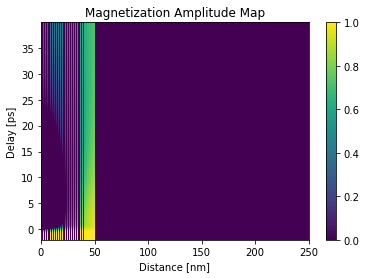

In [17]:
plt.figure()
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map[:, :, 0], shading='auto')
plt.title('Magnetization Amplitude Map')
plt.ylabel('Delay [ps]')
plt.xlabel('Distance [nm]')
plt.colorbar()
plt.show()

## Initialize dynamical magnetic X-ray simulations

The `XrayDynMag` class requires a `Structure` object and a boolean `force_recalc` in order overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can using the boolean switch `progress_bar`.

In [18]:
dyn_mag = ud.XrayDynMag(S, True)
dyn_mag.disp_messages = True
dyn_mag.save_data = False

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized


## Homogeneous magnetic X-ray scattering

For the case of homogeneously strained/magnetized samples, the dynamical magnetic X-ray scattering simulations can be greatly simplified, which saves a lot of computational time.

### $q_z$-scan

The `XrayDynMag` object requires an `energy` and scattering vector `qz` to run the simulations.  
Both parameters can be arrays and the resulting reflectivity has a first dimension for the photon energy and the a second for the scattering vector.

The resulting reflectivity is always calculated for the actual magnetization (`R_hom`) of the sample, as well as for opposite magnetization (`R_hom_phi`).

In [19]:
dyn_mag.energy = np.r_[600, 708]*u.eV  # set two photon energies
dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm  # qz range

R_hom, R_hom_phi, _, _ = dyn_mag.homogeneous_reflectivity()  # this is the actual calculation

Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.177546 s


In this example half-order antiferromagnetic Bragg peaks appear only at the resonance.

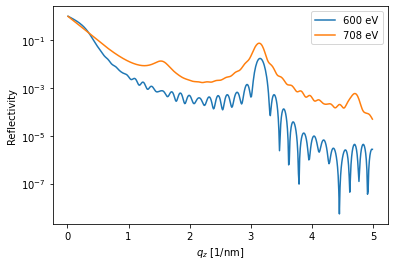

In [20]:
plt.figure()
plt.semilogy(dyn_mag.qz[0, :], R_hom[0, :], label='{}'.format(dyn_mag.energy[0]))
plt.semilogy(dyn_mag.qz[1, :], R_hom[1, :], label='{}'.format(dyn_mag.energy[1]))
plt.ylabel('Reflectivity')
plt.xlabel(r'$q_z$ [1/nm]')
plt.legend()
plt.show()

### Post-Processing

Simple convolution of the results with an arbitrary function handle.

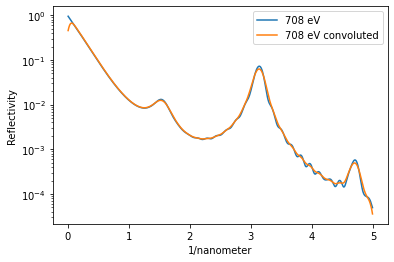

In [21]:
FWHM = 0.01/1e-10  # Angstrom
sigma = FWHM/2.3548

handle = lambda x: np.exp(-((x)/sigma)**2/2)
y_conv = dyn_mag.conv_with_function(R_hom[1, :], dyn_mag._qz[1, :], handle)

plt.figure()
plt.semilogy(dyn_mag.qz[0, :], R_hom[1, :], label='{}'.format(dyn_mag.energy[1]))
plt.semilogy(dyn_mag.qz[0, :], y_conv, label='{} convoluted'.format(dyn_mag.energy[1]))
plt.ylabel('Reflectivity')
plt.legend()
plt.show()

### Energy- and $q_z$-scan

In [22]:
dyn_mag.energy = np.r_[690:730:0.1]*u.eV  # set the energy range
dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm  # qz range

R_hom, R_hom_phi, _, _ = dyn_mag.homogeneous_reflectivity()  # this is the actual calculation

Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 29.441128 s


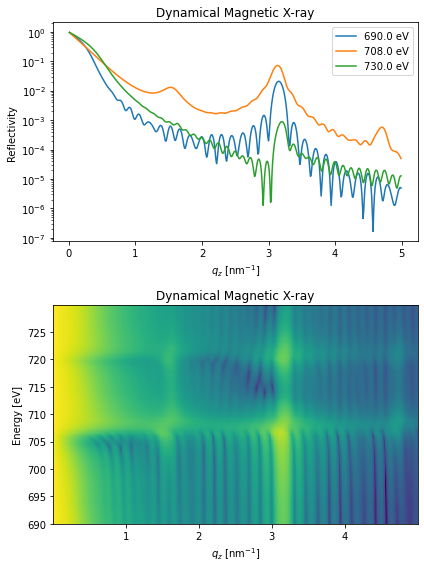

In [23]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_hom[0, :], label=np.round(dyn_mag.energy[0]))
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_hom[180, :], label=np.round(dyn_mag.energy[180]))
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_hom[-1, :], label=np.round(dyn_mag.energy[-1]))

plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.ylabel('Reflectivity')
plt.legend()
plt.title('Dynamical Magnetic X-ray')

plt.subplot(2, 1, 2)
plt.pcolormesh(dyn_mag.qz[0, :].to('1/nm').magnitude, dyn_mag.energy.magnitude, np.log10(R_hom[:, :]), shading='auto')
plt.title('Dynamical Magnetic X-ray')
plt.ylabel('Energy [eV]')
plt.xlabel('$q_z$ [nm$^{-1}$]')

plt.tight_layout()
plt.show()

### Polarization dependence

The `XrayDynMag` allows to set the incoming and outgoing polarization of the X-rays.

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.116459 s
incoming polarizations set to: sigma
analyzer polarizations set to: sigma
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.091620 s
incoming polarizations set to: sigma
analyzer polarizations set to: pi
Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.087906 s


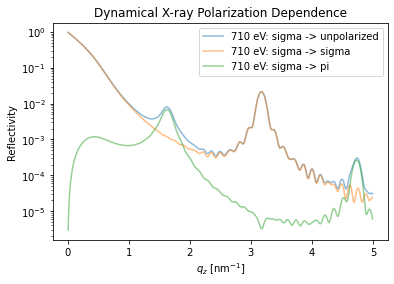

In [24]:
dyn_mag.energy = np.r_[710]*u.eV  # set two photon energies
dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm  # qz range

plt.figure()
dyn_mag.set_polarization(3, 0)
R_hom, R_hom_phi, _, _ = dyn_mag.homogeneous_reflectivity()  # this is the actual calculation
plt.semilogy(dyn_mag.qz[0, :], R_hom[0, :], label='{}: sigma -> unpolarized'.format(dyn_mag.energy[0]), alpha=0.5)

dyn_mag.set_polarization(3, 3)
R_hom, R_hom_phi, _, _ = dyn_mag.homogeneous_reflectivity()  # this is the actual calculation
plt.semilogy(dyn_mag.qz[0, :], R_hom[0, :], label='{}: sigma -> sigma'.format(dyn_mag.energy[0]), alpha=0.5)

dyn_mag.set_polarization(3, 4)
R_hom, R_hom_phi, _, _ = dyn_mag.homogeneous_reflectivity()  # this is the actual calculation
plt.semilogy(dyn_mag.qz[0, :], R_hom[0, :], label='{}: sigma -> pi'.format(dyn_mag.energy[0]), alpha=0.5)

plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.ylabel('Reflectivity')
plt.title('Dynamical X-ray Polarization Dependence')
plt.legend()
plt.show()

## Inhomogeneous dynamical magnetic X-ray scattering

The `inhomogeneous_reflectivity()` method allows to calculate the transient magnetic X-ray reflectivity according to a `strain_map` and/or `magnetization_map`.

In [25]:
dyn_mag.energy = np.r_[708]*u.eV  # set the energy range
dyn_mag.qz = np.r_[1:3.5:0.01]/u.nm  # qz range
dyn_mag.set_polarization(3, 0)

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized


In [26]:
R_seq, R_seq_phi, _, _ = dyn_mag.inhomogeneous_reflectivity(strain_map=strain_map,
                                                            magnetization_map=magnetization_map)

Calculating _inhomogeneous_reflectivity_ ...


Progress:   0%|          | 0/420 [00:00<?, ?it/s]

Elapsed time for _inhomogeneous_reflectivity_: 173.128203 s


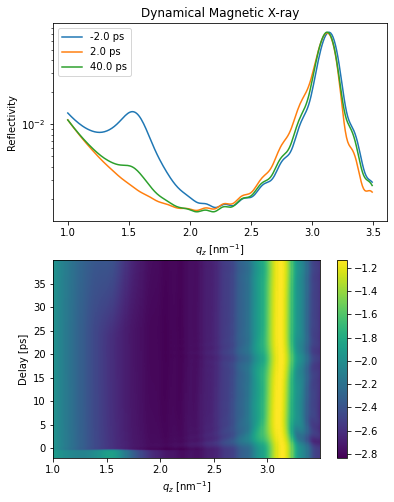

In [27]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_seq[0, 0, :], label=np.round(delays[0]))
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_seq[40, 0, :], label=np.round(delays[40]))
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_seq[-1, 0, :], label=np.round(delays[-1]))

plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.ylabel('Reflectivity')
plt.legend()
plt.title('Dynamical Magnetic X-ray')

plt.subplot(2, 1, 2)
plt.pcolormesh(dyn_mag.qz[0, :].to('1/nm').magnitude,
               delays.to('ps').magnitude, np.log10(R_seq[:, 0, :]), shading='auto')

plt.ylabel('Delay [ps]')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.colorbar()
plt.show()

## Parallel dynamical X-ray scattering

Parallelization is fundamentally implemented but needs further improvements.
It works similar as with `XrayDyn`.

You need to install the `udkm1Dsim` with the `parallel` option which essentially add the `Dask` package to the requirements:

```
> pip install udkm1Dsim[parallel]
```

You can also install/add `Dask` manually, e.g. via pip:

```
> pip install dask
```

Please refer to the [Dask documentation](https://docs.dask.org/en/latest/) for more details on parallel computing in Python.


In [28]:
try:
    from dask.distributed import Client
    client = Client()
    R_seq_par, R_seq_phi_par, _, _ = dyn_mag.inhomogeneous_reflectivity(strain_map=strain_map,
                                                                        magnetization_map=magnetization_map,
                                                                        calc_type='parallel', dask_client=client)
    client.close()
except:
    pass

Calculating _inhomogeneous_reflectivity_ ...
Elapsed time for _inhomogeneous_reflectivity_: 231.048072 s


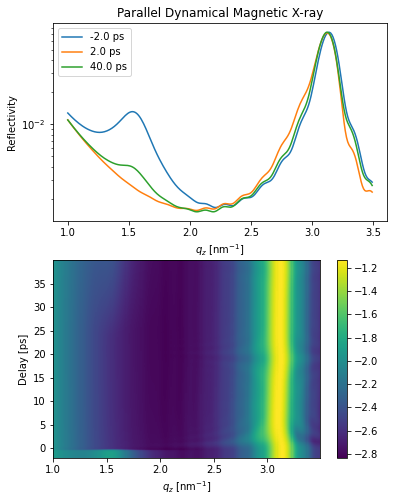

In [29]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_seq_par[0, 0, :], label=np.round(delays[0]))
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_seq_par[40, 0, :], label=np.round(delays[40]))
plt.semilogy(dyn_mag.qz[0, :].to('1/nm'), R_seq_par[-1, 0, :], label=np.round(delays[-1]))

plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.ylabel('Reflectivity')
plt.legend()
plt.title('Parallel Dynamical Magnetic X-ray')

plt.subplot(2, 1, 2)
plt.pcolormesh(dyn_mag.qz[0, :].to('1/nm').magnitude,
               delays.to('ps').magnitude, np.log10(R_seq_par[:, 0, :]), shading='auto')

plt.ylabel('Delay [ps]')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.colorbar()
plt.show()